# Clustering

The goal of this step is to present the users with a set of key terms for the data and allow them to select interesting tags interactively to narrow the results.

The process can be divided into two stages:

1. Data preprocessing
2. User interaction

Stage (1) comprises two main procedures. First, the terms are transformed into *term vectors*, where each column corresponds to each term in the dataset and each row corresponds to each document. The elements are then assigned weights; these can be either a simple binary measures (1 - the term is present in the given document; 0 - the term does not appear in the document) or statistical ranks of importance of the given term to the given document (such as TF-IDF or G2).

    Example: for the documents ["Mary had", "a little lamb"], term vectors with a binary measure would be (let's assume the terms are sorted in alphabatical order):

    [[0, 1, 0, 0, 1], #Document 1
    [1, 0, 1, 1, 0]]
    
The second step of data preprocessing is to calculate, for each document, its K nearest neighbours. These will be used to find the most relevant terms for display after the user selects a tag at the user interaction stage.

Stage (2) is user interaction. Initially, a set of highest-ranking terms for the entire dataset (calculated on the basis of the term vectors) is displayed to the user along with an input field. Once the user selects a term from the list, documents containing the term are selected. For each of the matched document, its neighbours are selected from the nearest neighbour list. Finally, the terms of the matched documents and neghbours are used to generate a more focused input list for user selection and the process is repeated.

In [1]:
import os
from sklearn.neighbors import NearestNeighbors
from math import log
import pandas as pd
import numpy as np
import pickle

In [2]:
# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, 'data')
print("Data directory: %s" % data_dir)

Data directory: /Users/Lo/Work/CS109Project/data


# Visualization

In [3]:
freq_map = pd.read_pickle(os.path.join(data_dir, 'clust_fm.pckl'))
agg_df = pd.read_pickle(os.path.join(data_dir, 'clust_agg.pckl'))
term_vectors = pd.read_pickle(os.path.join(data_dir, 'clust_tv.pckl'))
cluster_distances = pd.read_pickle(os.path.join(data_dir, 'clust_cd.pckl'))
cluster_indices = pd.read_pickle(os.path.join(data_dir, 'clust_ci.pckl'))

In [4]:
print freq_map.head(1)
print agg_df.head(1)
print "term vectors ", term_vectors[:1]
print "cluster distances ", cluster_distances[:1]
print "cluster indices ", cluster_indices[:1]

C0030705    11009
dtype: int64
                                                           cui
nct_id                                                        
NCT00001149  [C0040223, C0036572, C0036572, C0036572, C0036...
term vectors  [[ 14.8128593   37.30007803  13.02812593 ...,  12.15295183  12.15295183
   12.15295183]]
cluster distances  [[   0.           93.31178852   93.66380314   94.12704914   95.19694905
    97.43091189  100.3290533   100.75898977  101.4364923   103.48011933
   103.48011933  104.24313524  104.56179182  104.56179182  105.39721088
   105.82771367  106.25881991  106.42520011  107.46472589  109.14112335
   109.33192919  109.39265497  110.52060886  110.92849206  111.42259738
   111.68539836  112.30471041  113.05963719  113.11786131  113.24679806
   114.47804894  115.47911562  115.75610067  115.9610434   116.39303363
   116.47096291  116.99106118  117.09657812  117.12366192  117.17099926
   117.17099926  117.30998545  117.54677826  117.95252103  118.13667599
   118.540

In [5]:
!pip install graphviz
!pip install pygraphviz

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


removed nodes:  393


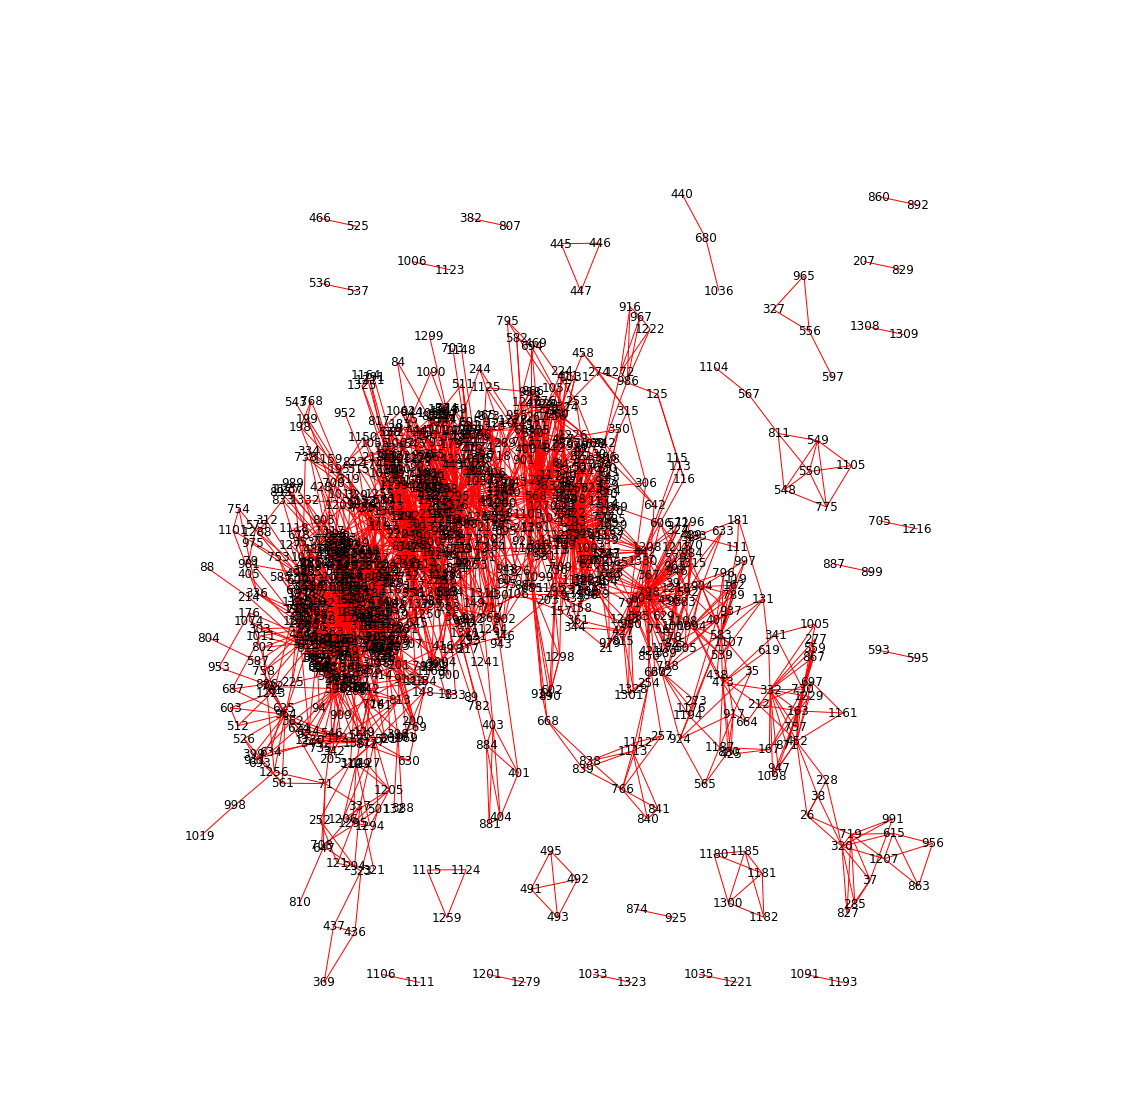

In [27]:
#cluster map of all
s = len(cluster_indices[:])
nbs = 4
removed = []
plt.figure(figsize=(15,15)) 
G = nx.Graph()
for i in range(len(cluster_indices[:s])):
    G.add_node(i)
    indicator = False
    for (count, k) in enumerate(cluster_indices[i][1:nbs]):
        if cluster_distances[i][1:][count] < 200:
            indicator = True
            G.add_node(k)
            G.add_edges_from([(i,k)], length=cluster_distances[i][1:][count])
    if not indicator:
        G.remove_node(i)
        removed.append(i)
print "removed nodes: ", len(removed)

pos = nx.spring_layout(G, scale=1)
#pos = nx.spring_layout(G, k=0.2,iterations=10)

nx.draw_graphviz(G, with_labels=True, node_color='w',node_size=0, edge_color="r")
plt.show()

In [ ]:
#cluster map of one node and its connections
s = 5
nn = 0
plt.figure(figsize=(15,10)) 
G = nx.Graph()
G.add_node(nn)
for (count, k) in enumerate(cluster_indices[nn][:]):
    if cluster_distances[nn][count] < 110:
        print k,cluster_distances[nn][count]
        G.add_node(k)
        G.add_edges_from([(nn,k)], length=cluster_distances[nn][count])

pos = nx.spring_layout(G, k=0.2,iterations=10)

nx.draw_networkx(G, pos, with_labels=True, node_color='w',node_size=0, label_color='r')
plt.show()        
        

In [15]:
cluster_distances

array([[   0.        ,   93.31178852,   93.66380314, ...,  119.49919818,
         119.97776932,  120.25679452],
       [   0.        ,  145.83035197,  153.42381646, ...,  165.8667318 ,
         166.03274386,  166.1685143 ],
       [   0.        ,  319.26218212,  328.75135917, ...,  368.94239932,
         368.97833206,  369.14643867],
       ..., 
       [   0.        ,  244.77781111,  246.4852524 , ...,  262.87615137,
         262.99237853,  263.21378749],
       [   0.        ,  172.9420408 ,  182.72826205, ...,  201.91931998,
         202.07890305,  202.29409231],
       [   0.        ,  259.93173628,  260.66232062, ...,  271.19553016,
         271.57118673,  272.06184304]])